# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
PATH_MODELS = '/data/logits_torchvision'
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '../..')
sys.path.insert(1, '../../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split_data
import post_hoc

# Evaluate logits

In [5]:
DATASET = 'ImageNet'
VAL_SIZE = 0.1 #5000
METRIC = metrics.AURC

In [6]:
scenarios = ['Modern', 'Old']
methods = {'MSP': lambda logits,T : measures.MSP(logits),
           'MSP-TS-NLL': lambda logits,T :measures.MSP(logits.div(T)),
           'MSP-TS-AURC': lambda logits,T :measures.MSP(logits.div(T)),
           'LogitsMargin': lambda logits,T :measures.margin_logits(logits)}

In [7]:
naurc_d = {scenarios[0] : {method:defaultdict(list) for method in methods},
           scenarios[1]: {method:defaultdict(list) for method in methods}}

sac_d = {scenarios[0]:{method:defaultdict(list) for method in methods.keys()},
        scenarios[1]: {method:defaultdict(list) for method in methods.keys()}}

In [8]:

for model_arc in os.listdir(os.path.join(PATH_MODELS,'logits')):
    print(model_arc)
    if '_New' in model_arc:
        group = scenarios[0]
    elif '_Old' in model_arc:
        group = scenarios[1]
    else: print('Ignoring'); continue
    seed = SEED
    for i in range(5):
        logits_val,labels_val,logits_test,labels_test = split_data.split_logits(torch.load(os.path.join(PATH_MODELS,'logits',model_arc)),
                                                                                torch.load(os.path.join(PATH_MODELS,'ImageNet_val_labels.pt'))
                                                                                ,VAL_SIZE,seed)
        risk_val = measures.wrong_class(logits_val,labels_val).float()
        risk_test = measures.wrong_class(logits_test,labels_test).float()

        for method,fn in methods.items():
            if 'NLL' in method: T = post_hoc.optimize.T(logits_val,labels_val,metric = torch.nn.CrossEntropyLoss(),method = lambda x: x)
            else: T = post_hoc.optimize.T(logits_val,risk_val,metric =  METRIC)
            naurc_d[group][method][model_arc].append(metrics.N_AURC(fn(logits_test,T),risk_test))
            sac_d[group][method][model_arc].append(metrics.SAC(fn(logits_test,T),risk_test,0.98))
        seed += 11

ResNeXt101_32X8D_New.pt
MobileNet_V3_Large_Old.pt
RegNet_Y_800MF_Old.pt
Wide_ResNet101_2_New.pt
MaxVit_T_OTHER.pt
Ignoring
RegNet_Y_1_6GF_New.pt
RegNet_X_1_6GF_Old.pt
SqueezeNet1_1_OTHER.pt
Ignoring
RegNet_X_16GF_Old.pt
RegNet_Y_800MF_New.pt
RegNet_Y_400MF_Old.pt
ResNeXt101_64X4D_OTHER.pt
Ignoring
RegNet_Y_8GF_Old.pt
MNASNet0_5_OTHER.pt
Ignoring
Swin_B_OTHER.pt
Ignoring
RegNet_Y_1_6GF_Old.pt
ResNet101_Old.pt
RegNet_Y_32GF_New.pt
RegNet_Y_400MF_New.pt
RegNet_X_32GF_Old.pt
VGG19_OTHER.pt
Ignoring
ViT_B_16_OTHER.pt
Ignoring
Swin_V2_S_OTHER.pt
Ignoring
ResNeXt50_32X4D_New.pt
EfficientNet_B3_OTHER.pt
Ignoring
RegNet_X_16GF_New.pt
VGG11_OTHER.pt
Ignoring
RegNet_X_32GF_New.pt
ConvNeXt_Large_OTHER.pt
Ignoring
MobileNet_V2_Old.pt
ResNeXt101_32X8D_Old.pt
EfficientNet_B4_OTHER.pt
Ignoring
Swin_V2_B_OTHER.pt
Ignoring
ShuffleNet_V2_X0_5_OTHER.pt
Ignoring
Inception_V3_OTHER.pt
Ignoring
Swin_S_OTHER.pt
Ignoring
ShuffleNet_V2_X2_0_OTHER.pt
Ignoring
ResNet152_Old.pt
Wide_ResNet50_2_Old.pt
EfficientNet_

In [16]:
means_naurc = {}
std_naurc = {}
for group in scenarios:
    means_naurc[group] = {}
    std_naurc[group] = {}
    for method in methods:
        means_naurc[group][method] = np.mean(list(naurc_d[group][method].values()),-1)
        std_naurc[group][method] = np.std(list(naurc_d[group][method].values()),-1)

gains_naurc = {}
for group in scenarios:
    gains_naurc[group] = {}
    baseline = means_naurc[group]['MSP']
    for method in methods:
        gains_naurc[group][method] = means_naurc[group][method]-baseline

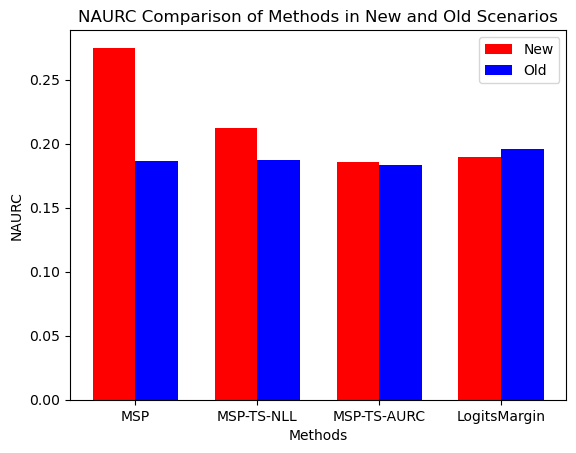

In [17]:
width = 0.35  # Width of the bars
x = np.arange(len(methods))
# Calculate NAURC as the mean of each array
new_naurc = [np.mean(means_naurc[scenarios[0]][method]) for method in methods]
old_naurc = [np.mean(means_naurc[scenarios[1]][method]) for method in methods]

# Plotting
fig, ax = plt.subplots()
bars_new = ax.bar(x - width/2, new_naurc, width, label='New', color='red')
bars_old = ax.bar(x + width/2, old_naurc, width, label='Old', color='blue')

# Labels and title
ax.set_xlabel('Methods')
ax.set_ylabel('NAURC')
ax.set_title('NAURC Comparison of Methods in New and Old Scenarios')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

plt.show()

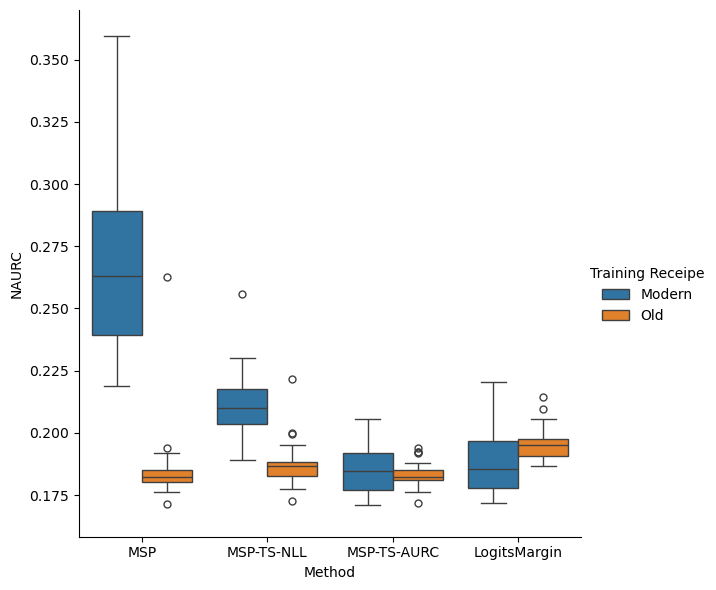

In [22]:
import pandas as pd
rows = []
for scenario, methods in means_naurc.items():
    for method, values in methods.items():
        for value in values:
            rows.append({'Method': method, 'NAURC': value, 'Training Receipe': scenario})

df = pd.DataFrame(rows)

# Create the catplot
sns.catplot(x='Method', y='NAURC', hue='Training Receipe', kind='box', data=df, height=6, aspect=1)
plt.ylim(top = 0.37)
# Customize the plot
#plt.title('NAURC Comparison of Methods in New and Old Scenarios')
plt.savefig(os.path.join(FIGS_PATH, f'NAURC_models_training.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

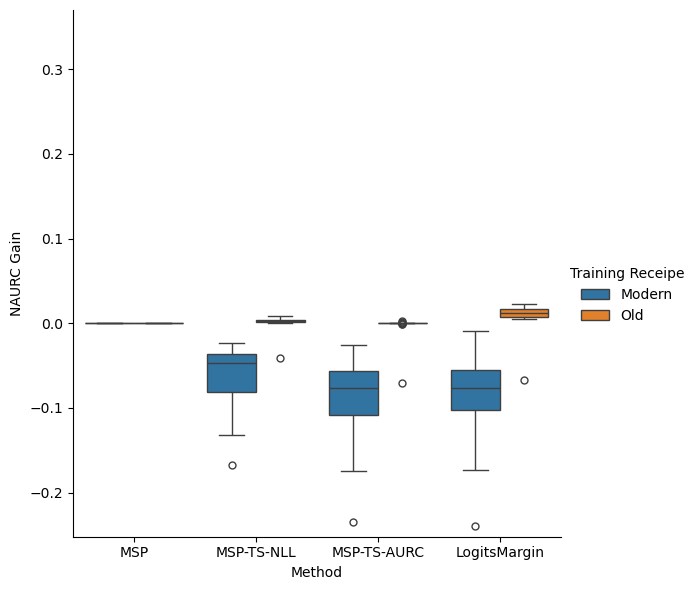

In [23]:
import pandas as pd
rows = []
for scenario, methods in gains_naurc.items():
    for method, values in methods.items():
        for value in values:
            rows.append({'Method': method, 'NAURC Gain': value, 'Training Receipe': scenario})

df = pd.DataFrame(rows)

# Create the catplot
sns.catplot(x='Method', y='NAURC Gain', hue='Training Receipe', kind='box', data=df, height=6, aspect=1)
plt.ylim(top = 0.37)
# Customize the plot
#plt.title('NAURC Comparison of Methods in New and Old Scenarios')
plt.savefig(os.path.join(FIGS_PATH, f'NAURC_gains_models_training.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()